### Import packages

In [1]:
import random
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm

### Set seed

In [18]:
def same_seed(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
        # torch.mps.manual_seed_all(seed)
same_seed(2023)
device = torch.device("cpu")
print(device)

cpu


### Set config

In [20]:
config = {
    'batch_size' : 64,
    'n_epoch' :100,
    'lr' : 0.0002,
    'z_dim' : 100,       #dimension of random noise vector
    'hidden_gen' : 32,   
    'output_gen' : 784,  #28*28
    'input_disc' : 784,
    'hidden_disc' : 32,
    'output_disc' : 1,
}

### Transform data
Normalize the data

Tips: According the PyTorch document, 
> A Tensor Image is a tensor with (`C`, `H`, `W`) shape, where `C` is a number of channels, `H` and `W` are image height and width. A batch of Tensor Images is a tensor of (`B`, `C`, `H`, `W`) shape, where `B` is a number of images in the batch.

The function `ToTensor`:
> Converts a PIL Image or numpy.ndarray (`H` x `W` x `C`) in the range [0, 255] to a torch.FloatTensor of shape (`C`, `H`, `W`) in the range [0.0, 1.0]

In [4]:
# This function automatically scales the input data to the range of [0,1].
transform = transforms.Compose([
        # scale the image to [0.0, 1.0]
        transforms.ToTensor(),
        # normalize the mnist data
        # mnist data set is of one channel (black and white)
        # 0.1307 -> mean, 0.3081 -> std  
        transforms.Normalize((0.1307,), (0.3081,))
        ])

### Download MNIST data
Note that 'train_data' and 'train_labels' are the attributes of the dataest.

/Users/lerong/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/lerong/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


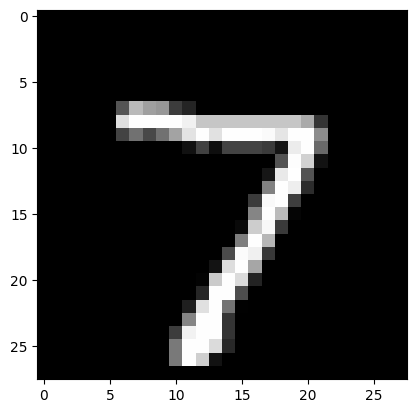

In [5]:
train_set = datasets.MNIST(root='./mnist', train=True, download=True,transform=transform)
train_set = train_set.train_data  # remove labels
#plt.imshow(train_set[0].numpy(),cmap='gray')

test_set = datasets.MNIST(root='./mnist', train=False, download=True,transform=transform)
test_set = test_set.test_data  # remove labels
plt.imshow(test_set[0].numpy(),cmap='gray')

train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

### Noise generator

In [6]:
def random_noise_generator(batch_size, dim):
    return torch.rand(batch_size, dim)*2 - 1

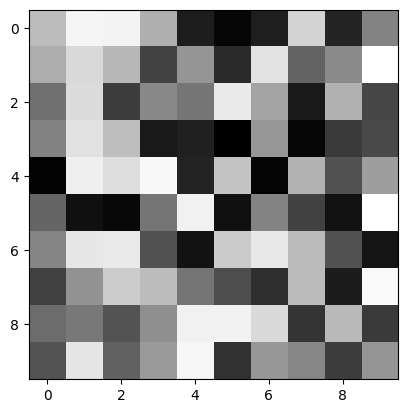

In [7]:
a = random_noise_generator(config['batch_size'], 100) # batch size=64
b = a[63]
b = b.reshape(10, 10)
b = b.numpy()
plt.imshow(b, cmap = 'gray')

### Initialize weights

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### GAN

In [9]:
#Generator
class Generator(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size*2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size*2, hidden_size*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_size*4, output_size),
            nn.Tanh(),
        )
        
    def forward(self, x):
        output = self.layers(x)
        return output

In [10]:
#Discriminator
class Discriminator(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_size*4, hidden_size*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_size*2, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, output_size),
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28) # reshape the tensor to 1-dimensional vector
        output = self.layers(x)
        return output        

### Loss functions
discriminator:
$$
J^D(\theta^D,\theta^G) = -\frac{1}{2}\mathbb{E}_{x\sim \mathbb{P}_{data}} \log D(x) -\frac{1}{2}\mathbb{E}_z \log (1-D(G(z)))
$$
generator:
$$
J^G=-\mathbb{E}_z[\log D(G(z))]
$$

Since the training data is finite, the expectation is simply $\frac{1}{n}\sum \cdots$. We could set `BCELoss` as the loss of discriminator:
$$
-\frac{1}{n}\left(\sum_{i=1}^n y_i\ln x_i+(1-y_i)\ln(1-x_i)\right)
$$
where $x_i$ is the model output and $y_i$ is the target.

However, people usually use `BCEWithLogitsLoss` to be the loss function, which is basically `BCELoss(Sigmoid(x))` where `x` is the model output. In general, the sigmoid function is used for the two-class logistic regression which outputs a value between 0 and 1. We indeed need sigmoid here since the output layer of `Discriminator` is `Linear`,ranging from $-\infty$ to $\infty$, which is not a probability. You can add `nn.Sigmoid` after `Linear` and  use `BCELoss` or 
 
`BCEWithLogitsLoss` looks like
$$
-\frac{1}{n}\left(\sum_{i=1}^n y_i\ln \sigma(x_i)+(1-y_i)\ln(1-\sigma(x_i))\right).
$$

Discriminator loss:
- When passing a real training image, the output values are compared with 1 (for real images) and real loss is calculated.
- When passing latent vector to the generator, a fake image is generated and passed to the discriminator, and the outputs are compared with 0 (for fake images) and fake loss is calculated.

`squeeze`: (`A`$\times$ 1 $\times$ `B` $\times$ 1 $\times$ `C`) to (`A`$\times$ `B` $\times$ `C`)

In [11]:
Loss = nn.BCEWithLogitsLoss()

def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)/2
    return total_loss

Generator loss:
- Since the generator wants to fool the discriminator, the output labels are compared with 1 (for supposedly real images) and loss is calculated.

In [12]:
def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

### Trainer

In [21]:
class TrainGAN():
      def __init__(self, config):
        
        self.config = config
        self.G = Generator(self.config['z_dim'], self.config['hidden_gen'], self.config['output_gen'])
        self.D = Discriminator(self.config['input_disc'], self.config['hidden_disc'], self.config['output_disc'])
        self.d_optimizer = optim.Adam(self.D.parameters(), lr = 0.0001, betas = (0.1, 0.999))
        self.g_optimizer = optim.Adam(self.G.parameters(), lr = 0.0001, betas = (0.1, 0.999))
        self.d_loss = discriminator_loss
        self.g_loss = generator_loss
        self.train_loader = train_loader

      def prepare_environment(self):
         self.D = self.D.to(device)
         self.G = self.G.to(device)

         self.D = self.D.float()
         self.G = self.G.float()

         self.D.train()
         self.G.train()
      def train(self):
         self.prepare_environment()

         disc_losses = []
         gen_losses = []

         sample_size = 16
         fixed_samples = random_noise_generator(sample_size, self.config['z_dim'])
         fixed_samples = fixed_samples.to(device)

         for epoch in range(self.config['n_epoch'] + 1):
            
            disc_loss_total = 0
            gen_loss_total = 0
            gen_out = 0
            
            for train_x in self.train_loader:
                  
                  #Discriminator training
                  self.d_optimizer.zero_grad()
                  
                  train_x = train_x.to(device)     #Passing to GPU
                  real_out = self.D(train_x.float())    
                  
                  disc_gen_in = random_noise_generator(self.config['batch_size'], self.config['z_dim'])
                  disc_gen_in = disc_gen_in.to(device)   #Passing to GPU
                  
                  disc_gen_out = self.G(disc_gen_in.float()).detach()  #Detaching to avoid training the generator
                  fake_out = self.D(disc_gen_out.float())
                  
                  disc_loss = self.d_loss(real_out, fake_out)  #Loss calculation
                  disc_loss_total += disc_loss
                  disc_loss.backward()
                  self.d_optimizer.step()  
            
                  #Generator training
                  self.g_optimizer.zero_grad()
                  
                  
                  gen_out = self.G(disc_gen_in.float())     #Feeding noise into the generator
                  gen_disc_out = self.D(gen_out.float())       #Passing into the discrminator
                  
                  gen_loss = self.g_loss(gen_disc_out)  #Generator loss calculation
                  gen_loss_total += gen_loss
                  gen_loss.backward()
                  self.g_optimizer.step()
            
            disc_losses.append(disc_loss_total)
            gen_losses.append(gen_loss_total)

            if epoch%10==0:
               self.G.eval()                    #Going into eval mode to get sample images         
               samples = self.G(fixed_samples.float())
               self.G.train()                   #Going back into train mode
                  
               fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
               for ax, img in zip(axes.flatten(), samples):
                  img = img.cpu().detach()
                  ax.xaxis.set_visible(False)
                  ax.yaxis.set_visible(False)
                  im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        
        
         #Printing losses every epoch
         print("Epoch ", epoch, ": Discriminator Loss = ", disc_loss_total/len(self.train_loader), ", Generator Loss = ", gen_loss_total/len(self.train_loader))    
    
    
         

Epoch  100 : Discriminator Loss =  tensor(2.4150e-06, grad_fn=<DivBackward0>) , Generator Loss =  tensor(19.7119, grad_fn=<DivBackward0>)


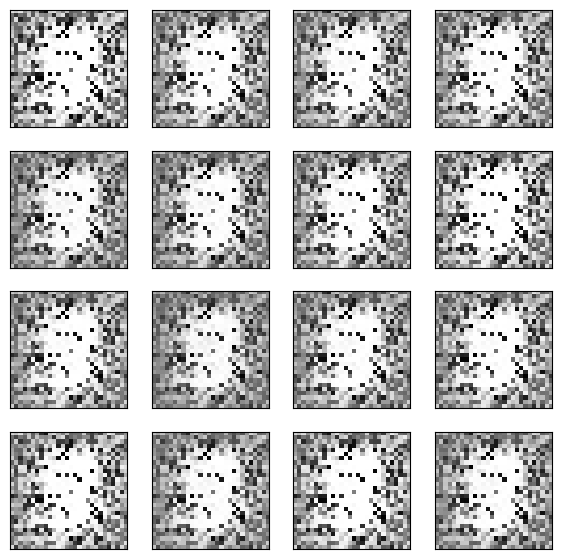

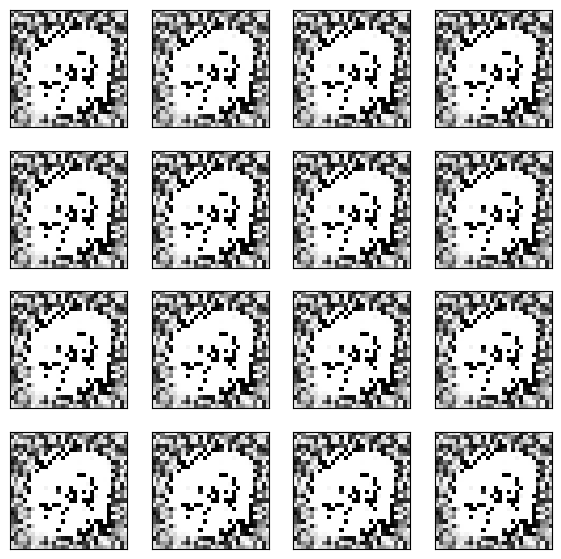

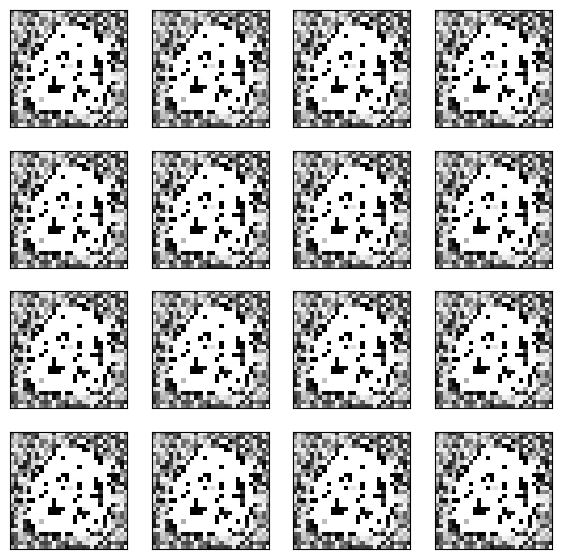

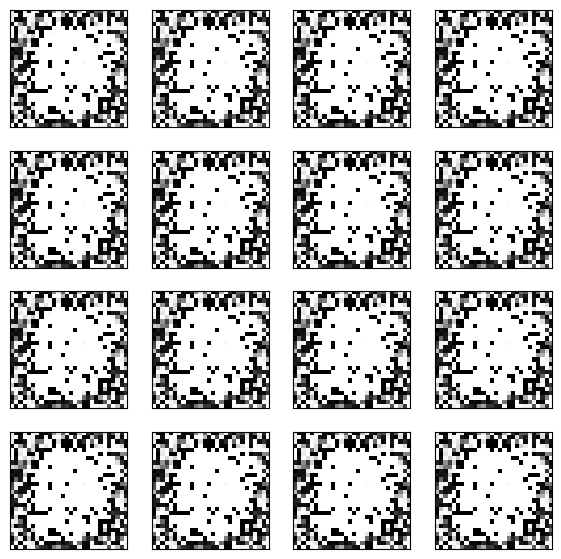

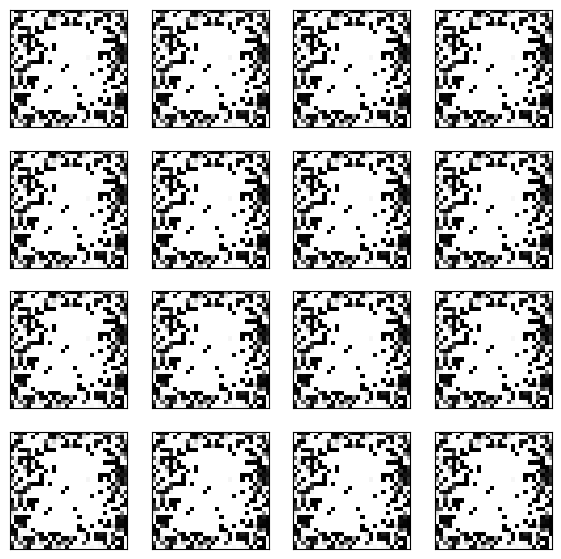

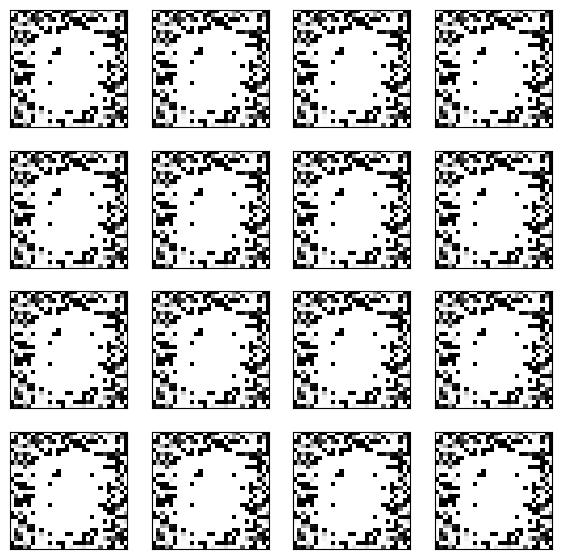

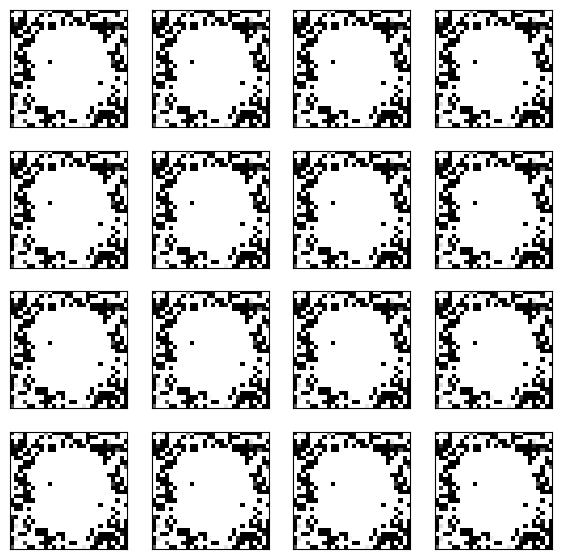

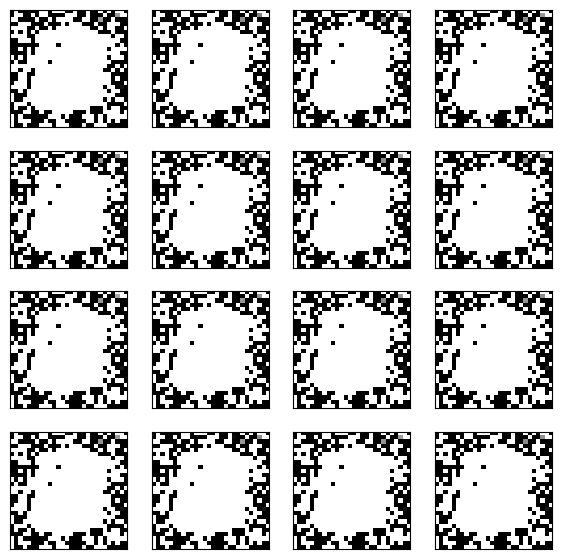

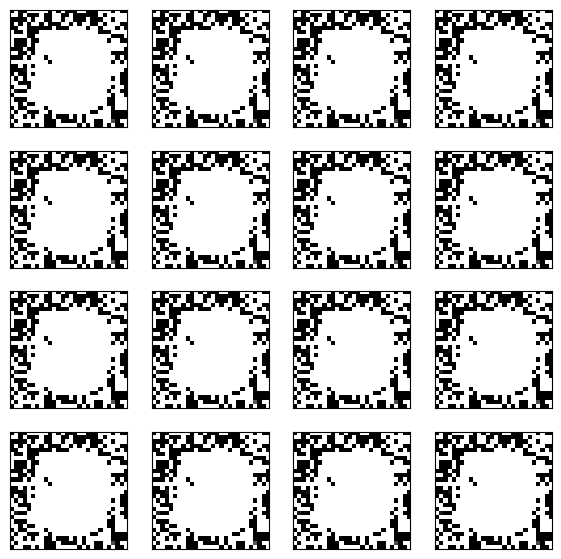

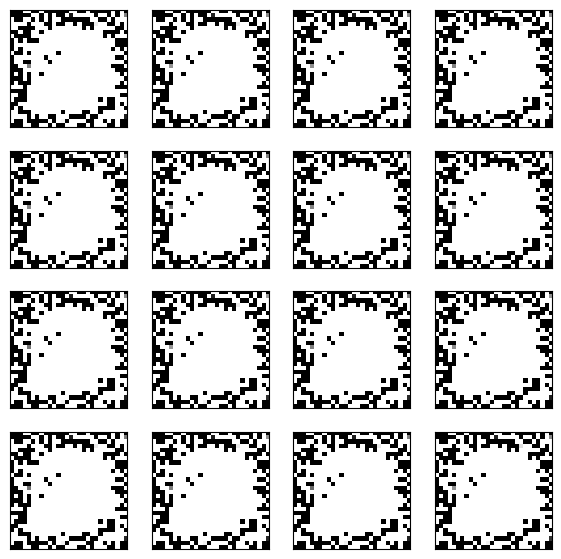

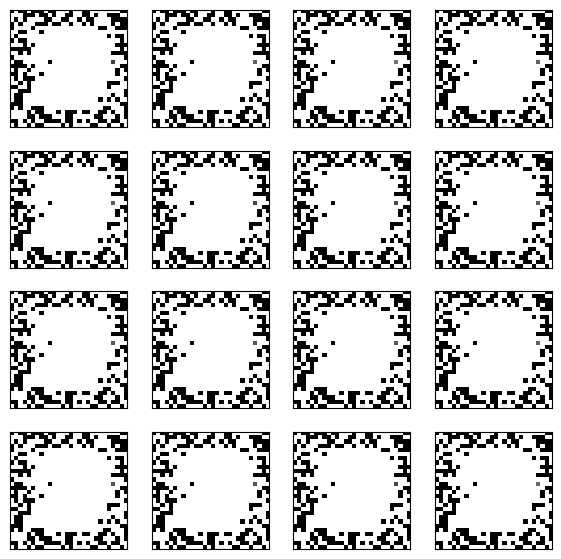

In [22]:
trainer = TrainGAN(config)
trainer.train()

### References
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://www.kaggle.com/code/tjac718/dcgan-on-mnist-dataset-using-pytorch